In [1]:
using NeuralPDE, Flux, ModelingToolkit, GalacticOptim, Optim, DiffEqFlux, CPUTime
import ModelingToolkit: Interval, infimum, supremum

@parameters t,x
@variables u(..)

Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dt = Differential(t)
Dx = Differential(x)

(::Differential) (generic function with 2 methods)

In [2]:
#2D PDE
eq  = Dt(u(t,x)) + u(t,x)*Dx(u(t,x)) - (0.01/pi)*Dxx(u(t,x)) ~ 0

# Initial and boundary conditions
bcs = [u(0,x) ~ -sin(pi*x),
       u(t,-1) ~ 0.,
       u(t,1) ~ 0.,
       u(t,-1) ~ u(t,1)]

# Space and time domains
domains = [t ∈ Interval(0.0,1.0),
           x ∈ Interval(-1.0,1.0)]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(t, 0.0..1.0)
 Symbolics.VarDomainPairing(x, -1.0..1.0)

In [3]:
#Discritization
dx = 0.05

chain = FastChain(FastDense(2,50,Flux.σ),FastDense(50,50,Flux.σ),
    FastDense(50,50,Flux.σ),FastDense(50,1))
discretization = PhysicsInformedNN(chain, GridTraining(dx))

#Problem formulation
@named pde_system = PDESystem(eq,bcs,domains,[t,x],[u])
prob = discretize(pde_system,discretization)


cb = function (p,l)
    println("Current loss is: $l")
    return false
end

# optimizer
opt = Optim.BFGS()
@time @CPUtime res = GalacticOptim.solve(prob,opt; cb = cb, maxiters=2200)
phi = discretization.phi

Current loss is: 1.0147008045016215
Current loss is: 0.5605044369788027
Current loss is: 0.4889294834297799
Current loss is: 0.45130372107743477
Current loss is: 0.450232142908962
Current loss is: 0.44623677458347694
Current loss is: 0.4456149874610884
Current loss is: 0.4454213438964976
Current loss is: 0.4453453354172762
Current loss is: 0.4449191201015674
Current loss is: 0.4447270751648537
Current loss is: 0.4444696982803388
Current loss is: 0.44409493960552343
Current loss is: 0.4434959098676273
Current loss is: 0.44270624377564394
Current loss is: 0.4393648304043607
Current loss is: 0.43567184214136084
Current loss is: 0.4292284643967716
Current loss is: 0.42786840127039955
Current loss is: 0.41655652295264567
Current loss is: 0.4095358659138559
Current loss is: 0.40953615078125544
Current loss is: 0.3754012049407738
Current loss is: 0.37540152249517705
Current loss is: 0.3657810367156164
Current loss is: 0.35791981267031303
Current loss is: 0.3428007609427043
Current loss is: 0.

Current loss is: 0.022652844652485588
Current loss is: 0.022239798365672404
Current loss is: 0.02179447844573553
Current loss is: 0.02124316743301297
Current loss is: 0.0208377814360448
Current loss is: 0.02038822299838259
Current loss is: 0.019720507713406537
Current loss is: 0.018998356142388758
Current loss is: 0.018492329238274263
Current loss is: 0.017959196627286664
Current loss is: 0.017503174258477583
Current loss is: 0.016757164671095823
Current loss is: 0.016496066832870415
Current loss is: 0.016127430352213007
Current loss is: 0.015839449356772894
Current loss is: 0.015592811972757237
Current loss is: 0.015415161120158173
Current loss is: 0.015149713707981054
Current loss is: 0.014897287216637013
Current loss is: 0.014580135553656096
Current loss is: 0.014281767333403889
Current loss is: 0.013605014905815423
Current loss is: 0.013071340224407962
Current loss is: 0.01258819479126632
Current loss is: 0.012428431684688728
Current loss is: 0.012165345094028713
Current loss is: 0

Current loss is: 0.0005275898753632133
Current loss is: 0.0005235759391913954
Current loss is: 0.0005205020834636485
Current loss is: 0.0005184641164180995
Current loss is: 0.0005159910429654183
Current loss is: 0.0005140499548359356
Current loss is: 0.0005098250983889855
Current loss is: 0.0005072897099874837
Current loss is: 0.0005042014029368338
Current loss is: 0.000501679235331535
Current loss is: 0.0004971176760496169
Current loss is: 0.0004916900540605366
Current loss is: 0.0004889809745803128
Current loss is: 0.00048682910244317995
Current loss is: 0.00048612311223381543
Current loss is: 0.000484048658798243
Current loss is: 0.00048132797130741225
Current loss is: 0.0004792461051129027
Current loss is: 0.0004750476034082285
Current loss is: 0.00047255603779219587
Current loss is: 0.0004711526319806337
Current loss is: 0.0004676704847626042
Current loss is: 0.00046676992154518
Current loss is: 0.0004647382958594776
Current loss is: 0.0004636286491809362
Current loss is: 0.000460

#298 (generic function with 1 method)

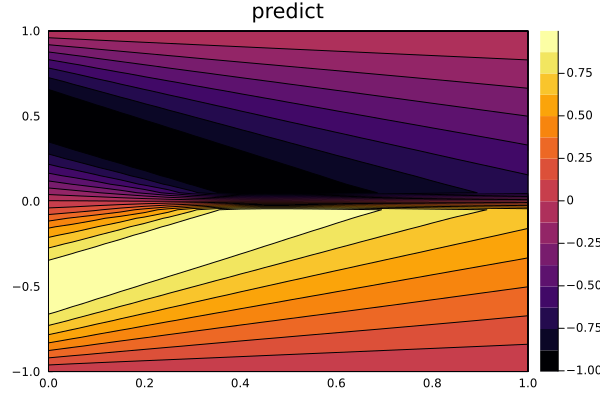

In [4]:
using Plots

ts,xs = [infimum(d.domain):dx:supremum(d.domain) for d in domains]
u_predict_contourf = reshape([first(phi([t,x],res.minimizer)) for t in ts for x in xs] ,length(xs),length(ts))
p1 = plot(ts, xs, u_predict_contourf, linetype=:contourf,title = "predict")
savefig("predictedBurgers.pdf")
plot(p1)

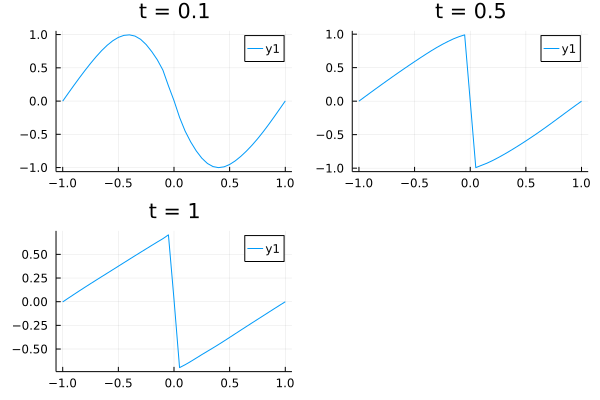

In [5]:
u_predict = [[first(phi([t,x],res.minimizer)) for x in xs] for t in ts ]
p1= plot(xs, u_predict[3],title = "t = 0.1");
savefig("Burgers_0.1sec.pdf")
p2= plot(xs, u_predict[11],title = "t = 0.5");
savefig("Burgers_0.5sec.pdf")
p3= plot(xs, u_predict[end],title = "t = 1");
savefig("Burgers_1.0sec.pdf")
plot(p1,p2,p3)